# Training a Neural Network To Predict Incubator Temperature

In this notebook we give you an example on how to train a new network to protect incubator temperature, from previous temperatures as well as control commands.

The network therefore has a similar interface to the incubator fmu created in previous notebooks.

## Dataset

The following is the dataset we will be using:

In [3]:
# Get CSV file from an incubator dataset
import sys
import os

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '3-Physics-Modelling', 'Current directory is not 3-Physics-Modelling'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

csv_file_path = os.path.join(parent_dir, 'incubator_dt', 'software', 'incubator', 'datasets', '20230501_calibration_empty_system', '20230501_calibration_empty_system.csv')

assert os.path.exists(csv_file_path), '20230501_calibration_empty_system.csv not found in the incubator repository.'

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(csv_file_path)
data['heater_on_int'] = data['heater_on'].astype(int)
data.head()

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed,heater_on_int
0,1682912554273107499,23.062,1682912554192856639,24.312,1682912554232822932,22.125,1682912554272705263,23.6870,False,False,3.0,1.025402,0
1,1682912557313698460,23.062,1682912557272792494,24.375,1682912557232848441,22.125,1682912557313344724,23.7185,False,False,3.0,1.064928,0
2,1682912560282455551,23.062,1682912560232232220,24.375,1682912560192178595,22.062,1682912560282224276,23.7185,False,False,3.0,1.031638,0
3,1682912563313803672,23.125,1682912563273056592,24.375,1682912563232827969,22.062,1682912563313317234,23.7500,False,False,3.0,1.061013,0
4,1682912566283347240,23.125,1682912566243313892,24.375,1682912566192896637,22.062,1682912566282895616,23.7500,False,False,3.0,1.028555,0


We will now create subplots to visualize the temperature and the control signal (heater) over time. This helps us understand how the data behaves and how the heater's state affects the temperature.

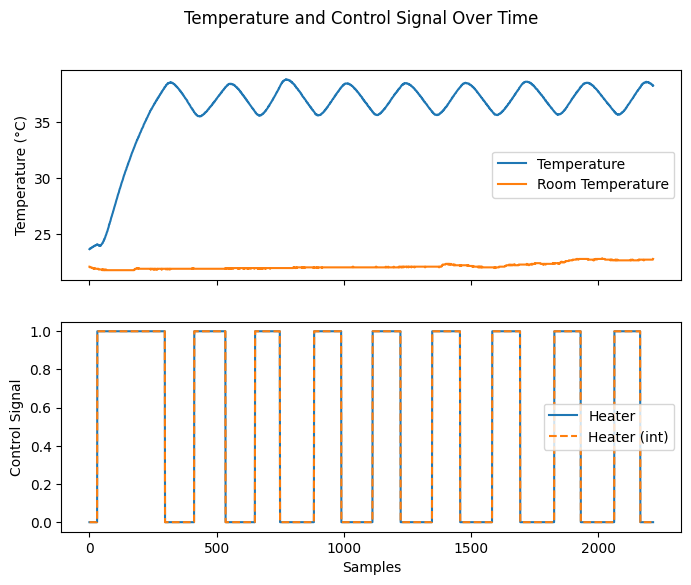

In [5]:
# Create subplots with shared X-axis for temperature and control signal.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot temperature data on the first subplot
ax1.plot(data.index, data.average_temperature, label='Temperature')
ax1.plot(data.index, data.t3, label='Room Temperature')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()

# Plot control signal data on the second subplot (heater on/off)
ax2.plot(data.index, data.heater_on, label='Heater')
ax2.plot(data.index, data.heater_on_int, label='Heater (int)', linestyle='--')  # Verification
ax2.set_xlabel('Samples')
ax2.set_ylabel('Control Signal')
ax2.legend()

# Add a title to the shared X-axis
fig.suptitle('Temperature and Control Signal Over Time')

# Show the plots
plt.show()

## Neural Network

### Problem Overview
The goal of the neural network is to predict the **next temperature** of a system based on historical data. In this case, the system measures:
- **Average temperature (`average_temperature`)**: This is the main feature we are trying to predict for the next time step.
- **Room temperature (`t3`)**: This is the ambient room temperature, which may influence the system’s temperature.
- **Heater state (`heater_on`)**: This binary value indicates whether the heater is on (1) or off (0), affecting how the temperature evolves.

We use these variables at a given time (let's call it time `t`) to predict the temperature at the next time step (`t+1`).

#### Inputs of the Neural Network
The neural network takes in **three inputs** at each time step `t` to make the prediction for time `t+1`:

1. **`previous_T` (previous average temperature)**:  
   This is the temperature of the system at time `t`. It captures the state of the system at the current time step. The neural network uses this to infer how much the temperature is likely to change.

2. **`previous_RoomT` (previous room temperature)**:  
   This is the room (ambient) temperature at time `t`. Since external conditions affect the temperature inside the system, knowing the room temperature helps the neural network understand the external environment's influence on the system.

3. **`previous_H` (previous heater state)**:  
   This is a binary feature indicating whether the heater was ON or OFF at time `t`. It has a significant impact on temperature dynamics since the heater increases the system’s temperature when ON. The neural network will learn how the heater state influences temperature changes.

These three input features form a **3-dimensional vector** representing the system's state at time `t`.

#### Outputs of the Neural Network
The neural network produces **one output**:

- **`next_T` (next average temperature)**:  
  This is the predicted average temperature at time `t+1`. The goal of the neural network is to learn the relationship between the current system state (given by the three input features) and the future temperature, so it can make accurate predictions.

Thus, the neural network's job is to map the input vector `[previous_T, previous_RoomT, previous_H]` to a scalar output `next_T`, which represents the system's temperature at the next time step.

#### Why These Inputs and Outputs?
- **Historical temperature**: The temperature of a system tends to evolve gradually, meaning that the current temperature is likely a good indicator of what the temperature will be in the near future. This is why `previous_T` is used as an input.
  
- **Room temperature**: If the room temperature is significantly different from the system’s temperature, it could cause the system’s temperature to change more rapidly (e.g., cooling down when the room is cold). Therefore, including `previous_RoomT` helps the model learn how external conditions affect the system.

- **Heater state**: The heater directly affects the temperature. When it’s on, the system’s temperature increases. By including `previous_H`, the model learns how much the heater impacts the temperature changes.

#### Neural Network Architecture
In this case, the architecture is a simple **linear regression model**:

- **Input layer**: Takes the three features `[previous_T, previous_RoomT, previous_H]`.
- **Output layer**: Produces a single output, which is the predicted `next_T` (the temperature at the next time step).

### Preparing the Dataset for Training

To make predictions, we need to use past data to predict future data. Here we shift the data to create input-output pairs: 
- The input (`previous_T`) is the temperature at time `t`.
- The output (`next_T`) is the temperature at time `t+1`.

In [6]:
# Prepare training data with shifted time series
nn_data = pd.DataFrame()

# Use previous temperature, room temperature, and heater state as inputs
nn_data['previous_T'] = data.loc[0:data.index[-2], 'average_temperature']
nn_data['previous_RoomT'] = data.loc[0:data.index[-2], 't3']
nn_data['previous_H'] = data.loc[0:data.index[-2], 'heater_on_int']

# The target is the next temperature
nn_data['next_T'] = data.loc[1:data.index[-1], 'average_temperature'].to_numpy()

# Verify that the data is aligned correctly
for i in range(0, nn_data.index[-2]):
    assert nn_data.loc[i+1,'previous_T'] == nn_data.loc[i,'next_T']

nn_data.head()

,previous_T,previous_RoomT,previous_H,next_T
0,23.6870,22.125,0,23.7185
1,23.7185,22.125,0,23.7185
2,23.7185,22.062,0,23.7500
3,23.7500,22.062,0,23.7500
4,23.7500,22.062,0,23.7500


#### Splitting Data into Training and Testing Sets

We split the data into training and testing sets to evaluate the model's performance. Typically, around 70% of the data is used for training, and 30% for testing.

In [7]:
rows_to_drop = int(0.3 * len(nn_data))
training_data = nn_data.iloc[:-rows_to_drop]
test_data = nn_data.iloc[-rows_to_drop:]

# Verify that the split was done correctly
assert len(training_data) + len(test_data) == len(nn_data)

#### Convert Data to Tensors for PyTorch

PyTorch models require input data in the form of tensors. We convert the input features (`previous_T`, `previous_RoomT`, `previous_H`) and the target (`next_T`) into tensors.

In [12]:
import torch

# Function to convert pandas DataFrame into PyTorch tensors
def convert_to_torch_inputs_outputs(df):
    X = torch.tensor(df[['previous_T', 'previous_RoomT', 'previous_H']].values, dtype=torch.float32)
    Y = torch.tensor(df[['next_T']].values, dtype=torch.float32)
    return X, Y

# Convert training data to tensors
X_train, Y_train = convert_to_torch_inputs_outputs(training_data)

In [13]:
X_train

tensor([[23.6870, 22.1250,  0.0000],
        [23.7185, 22.1250,  0.0000],
        [23.7185, 22.0620,  0.0000],
        ...,
        [36.9685, 22.0620,  0.0000],
        [36.9060, 22.0620,  0.0000],
        [36.9060, 22.0620,  0.0000]])

In [14]:
Y_train

tensor([[23.7185],
        [23.7185],
        [23.7500],
        ...,
        [36.9060],
        [36.9060],
        [36.8750]])

### Creating and Training the Neural Network

In [16]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model (a simple linear regression model)
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(3, 1)  # 3 input features and 1 output

    def forward(self, x):
        return self.linear(x)

# Initialize the model and define the loss function (Mean Squared Error)
model = LinearRegression()
model

LinearRegression(
  (linear): Linear(in_features=3, out_features=1, bias=True)
)

We use the Adam optimizer and train the model for 5000 epochs, updating the model’s parameters to minimize the loss (Mean Squared Error).

In [17]:
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 5000  # Number of epochs to train

# Define the loss function (Mean Squared Error)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Zero out gradients
    outputs = model(X_train)  # Forward pass
    loss = loss_fn(outputs, Y_train)  # Compute the loss
    loss.backward()  # Backpropagation
    
    optimizer.step()  # Update model parameters

    # Print loss periodically for monitoring
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [500/5000], Loss: 0.5271
Epoch [1000/5000], Loss: 0.4081
Epoch [1500/5000], Loss: 0.3010
Epoch [2000/5000], Loss: 0.2134
Epoch [2500/5000], Loss: 0.1413
Epoch [3000/5000], Loss: 0.0837
Epoch [3500/5000], Loss: 0.0427
Epoch [4000/5000], Loss: 0.0182
Epoch [4500/5000], Loss: 0.0064
Epoch [5000/5000], Loss: 0.0022


### Making Predictions and Visualizing Results

We use the trained model to predict the next temperature for the entire dataset. Then we compare the predicted values with the actual ones.

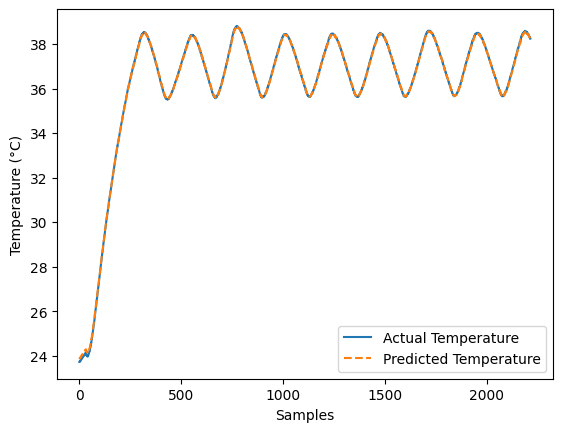

In [32]:
# Convert the full dataset to tensors and predict temperatures
X_full, _ = convert_to_torch_inputs_outputs(nn_data)
nn_data['next_T_predicted'] = model(X_full).detach().numpy()

# Plot actual vs. predicted temperatures
plt.plot(nn_data.index, nn_data.next_T, label='Actual Temperature')
plt.plot(nn_data.index, nn_data.next_T_predicted, label='Predicted Temperature', linestyle='--')
plt.ylabel('Temperature (°C)')
plt.xlabel('Samples')
plt.legend()

# Show the plot
plt.show()

## Packaging Model as an FMU and Coupling it with the Controller

Here we show to turn the above model into an FMU, and co-simulate it with a controller.

In [26]:
class IncubatorFMU:

    def __init__(self, model):
        """
        Initialize the IncubatorFMU.
        
        Parameters:
        - model: The pre-trained PyTorch neural network model.
        """
        self.model = model  # The trained neural network model
        self.time = 0.0

        # These will hold the inputs to the NN: previous temperature, room temperature, and heater state
        self.previous_Tb = 0.0
        self.Tr = 0.0
        self.H_h = 0  # Heater state (0: off, 1: on)

        # Latest temperature prediction from the NN model
        self.Tb = 0.0

    def fmi2Instantiate(self):
        """
        Instantiate the FMU.
        """

    def getTb(self):
        """
        Return the latest predicted box temperature from the NN model.
        """
        return self.Tb

    def fmi2SetupExperiment(self, start_time, stop_time):
        """
        Setup the simulation experiment.
        
        Parameters:
        - start_time: Start time of the simulation.
        - stop_time: End time of the simulation (not used directly here).
        """
        self.time = start_time

    def fmi2EnterInitializationMode(self):
        """
        FMU enters initialization mode. This is where initial conditions would be set.
        """

    def fmi2ExitInitializationMode(self):
        """
        FMU exits initialization mode and is ready to start the simulation.
        """

    def _predict_next_temperature(self):
        # Prepare the inputs to the NN model:
        nn_input = torch.tensor([[self.previous_Tb, self.Tr, self.H_h]], dtype=torch.float32)

        # Make the prediction with the neural network
        with torch.no_grad():  # No need to compute gradients during inference
            self.previous_Tb = self.Tb # Store previous temperature for next inference step.
            self.Tb = self.model(nn_input).item()

    def fmi2DoStep(self, current_time, step_size):
        """
        Perform one simulation step.
        
        Parameters:
        - current_time: The current simulation time.
        - step_size: The step size for the simulation.
        """
        next_time = current_time + step_size

        self._predict_next_temperature()

        # Update the current time and state for the next iteration
        self.time = next_time

    def fmi2Terminate(self):
        """
        Terminate the FMU simulation and free resources.
        """

In [27]:
class ControllerFMU:
    """
    A simple implementation of an FMU in Python for co-simulation.
    This FMU represents a thermostat controller with the states: Heating, and Cooling.
    The system adjusts the temperature based on the current room temperature, target temperature, and max temperature.
    """

    def __init__(self, max_temp, min_temp):
        # Initial state
        self.state = "Heating"
        self.heater_on = True
        self.time = 0.0  # Simulation start time

        # Temperature variables
        self.current_temp = 20.0  # Initial room temperature (Celsius)
        self.max_temp = max_temp  # Maximum allowed temperature (Celsius)
        self.min_temp = min_temp  # Minimum allowed temperature (Celsius)

    def fmi2Instantiate(self):
        """
        Simulate the FMU instantiation, which allocates resources and prepares the FMU.
        """
        self.time = 0.0
        self.state = "Heating"
        self.current_temp = 20.0

    def getHeaterSwitch(self):
        return 1 if self.heater_on else 0

    def fmi2SetupExperiment(self, start_time, stop_time):
        """
        Setup the simulation experiment.
        """
        self.time = start_time

    def fmi2EnterInitializationMode(self):
        """
        FMU enters initialization mode. This is where initial conditions would be set.
        """

    def fmi2ExitInitializationMode(self):
        """
        FMU exits initialization mode and is ready to start the simulation.
        """

    def fmi2DoStep(self, current_time, step_size):
        """
        Perform one simulation step. This simulates the thermostat's state machine.
        """
        # Update the simulation time
        self.time = current_time + step_size

        # State machine logic
        if self.state == "Heating":
            if self.current_temp >= self.max_temp:
                self.state = "Cooling" 
                self.heater_on = False

        elif self.state == "Cooling":
            if self.current_temp < self.min_temp:
                self.state = "Heating" 
                self.heater_on = True

    def fmi2Terminate(self):
        """
        Terminate the FMU simulation and free resources.
        """

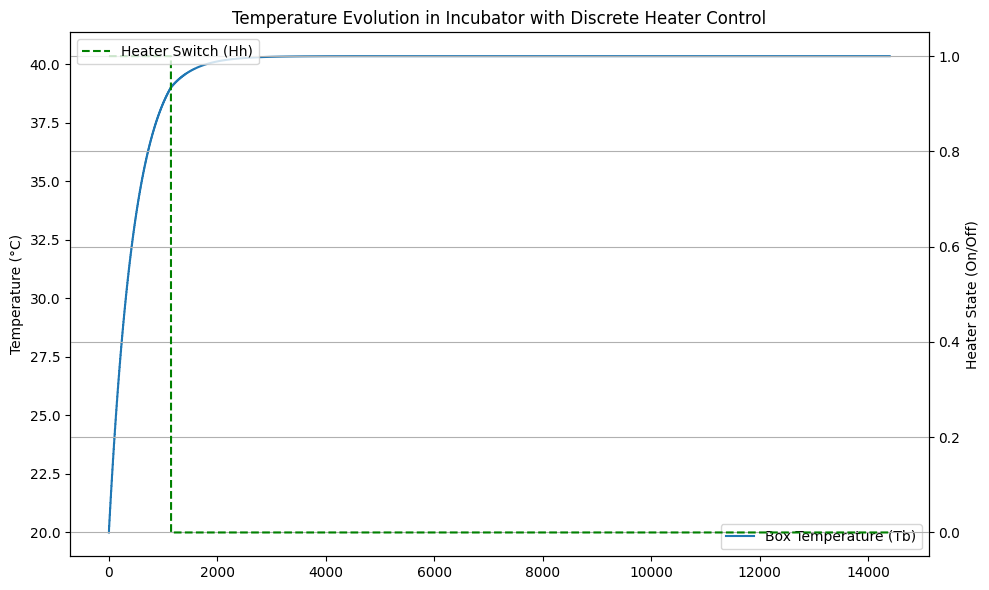

In [31]:
max_temp = 39.0 # Max temperature for controller (C)
min_temp = 36.0 # Min temperature for controller (C)

incubator_fmu = IncubatorFMU(model)
controller_fmu = ControllerFMU(max_temp, min_temp)

# Define the simulation parameters
t_start = 0.0
t_end = 4*3600.0  # Simulate for 4 hour (4*3600 seconds)
time_step = 3.0  # Step size for each segment of the simulation. Think of this as the execution interval of the controller that turns on and off the heater.

incubator_fmu.fmi2Instantiate()
incubator_fmu.fmi2SetupExperiment(t_start, t_end)
incubator_fmu.fmi2EnterInitializationMode()

controller_fmu.fmi2Instantiate()
controller_fmu.fmi2SetupExperiment(t_start, t_end)
controller_fmu.fmi2EnterInitializationMode()

# Set the inputs to the FMUs and initial values

incubator_fmu.previous_Tb = 20.0
incubator_fmu.Tr = 20.0
incubator_fmu.H_h = controller_fmu.getHeaterSwitch() 
incubator_fmu.Tb = 20.0
controller_fmu.current_temp = incubator_fmu.getTb()

incubator_fmu.fmi2ExitInitializationMode()
controller_fmu.fmi2ExitInitializationMode()

# Arrays to store the results
t_values = []
Tb_values = []
Hh_values = []

# While-loop simulation with discrete heater switching
current_time = t_start

# Store the initial values
t_values.append(current_time)
Tb_values.append(incubator_fmu.getTb())
Hh_values.append(controller_fmu.getHeaterSwitch())

while current_time < t_end:
    # Define the next time point for the step
    next_time = min(current_time + time_step, t_end)

    # Solve the ODE over this small time window
    incubator_fmu.fmi2DoStep(current_time, next_time-current_time)
    
    # Execute controller
    controller_fmu.fmi2DoStep(current_time, next_time-current_time)

    # Set the inputs to the FMUs
    controller_fmu.current_temp = incubator_fmu.getTb()
    incubator_fmu.H_h = controller_fmu.getHeaterSwitch()

    # Store the results
    t_values.append(next_time)
    Tb_values.append(incubator_fmu.getTb())
    Hh_values.append(controller_fmu.getHeaterSwitch())
    
    # Update the current time
    current_time = next_time

# Plot the results
# Plot the results with Hh_values on a secondary y-axis
plt.figure(figsize=(10, 6))

# Plot the temperatures on the primary y-axis
plt.plot(t_values, Tb_values, label='Box Temperature (Tb)')

plt.ylabel('Temperature (°C)')

plt.legend()

# Plot the heater switch on the secondary y-axis
plt.twinx()  # Create a second y-axis
plt.plot(t_values, Hh_values, label='Heater Switch (Hh)', color='green', linestyle='--')
plt.ylabel('Heater State (On/Off)')

# Labels and title
plt.title('Temperature Evolution in Incubator with Discrete Heater Control')
plt.xlabel('Time (seconds)')

# Grid, legend, and layout
plt.grid(True)
plt.legend(loc='upper left')  # Adjust legend position
plt.tight_layout()
plt.show()